In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn as skl
import theano
import pymc3 as pm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from itertools import combinations 

In [2]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import numpy as np

In [3]:
from conditional_independence import ConditionalIndependenceTester

# Missing Data IC* Algorithm


MissingDataDummifier
EuclideanDistanceDataPreprocessor

SkeletonFinder
    - take in dataset that has missing data. For each conditional independence test, remove data with missing rows relative to the conditional independence test.
- ConditionalIndependenceTester
  - ConditionallyIndependentDataGenerator

ImmoralitiesFinder

In [18]:
df = pd.DataFrame({ 'x': [1, 0, 1, 0, 1, 0], 'y': [1,1,1,0,0,0], 'z': [0, 1, 0, 0, 1, 1], 'p': [0, 0, 0, 0, 0, 0] })
df

,x,y,z,p
0,1,1,0,0
1,0,1,1,0
2,1,1,0,0
3,0,0,0,0
4,1,0,1,0
5,0,0,1,0


In [20]:
blah = df.groupby(['x', 'y', 'z']).count()
blah

p
x y z   
0 0 0  1
    1  1
  1 1  1
1 0 1  1
  1 0  2

In [39]:
df.groupby(['x', 'y']).count()[['p']]

p
x y   
0 0  2
  1  1
1 0  1
  1  2

In [38]:
df.groupby('y').count()[['p']]

,p
y,
0,3
1,3


In [42]:
(
    blah - (
        df.groupby(['x', 'y']).count()[['p']] / df.groupby(['y']).count()[['p']] \
        * df.groupby(['z', 'y']).count()[['p']] / df.groupby(['y']).count()[['p']] \
        * df.groupby(['y']).count()[['p']])
) ** 2

p
x y z          
0 0 0  0.111111
    1  0.111111
  1 1  0.111111
1 0 1  0.111111
  1 0  1.777778

In [45]:
(
(
    blah - (
        df.groupby(['x', 'y']).count()[['p']] / df.groupby(['y']).count()[['p']] \
        * df.groupby(['z', 'y']).count()[['p']] / df.groupby(['y']).count()[['p']] \
        * df.groupby(['y']).count()[['p']])
) ** 2 / (
        df.groupby(['x', 'y']).count()[['p']] / df.groupby(['y']).count()[['p']] \
        * df.groupby(['z', 'y']).count()[['p']] / df.groupby(['y']).count()[['p']] \
        * df.groupby(['y']).count()[['p']])

).sum()


p    3.333333
dtype: float64

In [37]:
x_given_y_counts = df.groupby(['x', 'y']).count()[['p']] / df.groupby('y').count()[['p']]
x_given_y_counts[['p']]

p
x y          
0 0  0.666667
  1  0.333333
1 0  0.333333
  1  0.666667

In [32]:
blah.groupby('x').count()

,p
x,
0,3
1,2


In [30]:
blah.index.names

FrozenList(['x', 'y', 'z'])

In [28]:
blah.loc[blah.index[0], 'p']

1

In [31]:
blah.at[blah.index[0], 'p']

1

In [94]:
class ChiSquareTest():
    def __init__(self, data, comparable_1, comparable_2, conditionals=[]):
        self.tmp_col_name = 'chi-sq. tmp count'
        self.data = data.copy()
        self.data[self.tmp_col_name] = 0
        self.num_rows = self.data.shape[0]
        
        self.comparable_1 = comparable_1
        self.comparable_2 = comparable_2
        self.conditionals = conditionals
        
        self.all_cols = [comparable_1, comparable_2]
        self.comparable_1_and_conditionals = [comparable_1]
        self.comparable_2_and_conditionals = [comparable_2]
        
        for conditional in conditionals:
            self.all_cols.append(conditional)
            self.comparable_1_and_conditionals.append(conditional)
            self.comparable_2_and_conditionals.append(conditional)

        self.joint_counts = self.data.groupby(self.all_cols).count()

    
    def statistic(self):
        if len(self.conditionals) > 0:
            # product of conditional counts of comparable_1 and comparable_2 and the 
            # marginal count of conditioning set
            
            proba_comparable_1_given_conditionals = \
                self.data.groupby(self.comparable_1_and_conditionals).count()[[self.tmp_col_name]] \
                / self.data.groupby(self.conditionals).count()[[self.tmp_col_name]]
            
            proba_comparable_2_given_conditionals = \
                self.data.groupby(self.comparable_2_and_conditionals).count()[[self.tmp_col_name]] \
                / self.data.groupby(self.conditionals).count()[[self.tmp_col_name]]
            
            self.prod = \
                self.num_rows * proba_comparable_1_given_conditionals \
                    * proba_comparable_2_given_conditionals \
                    * self.data.groupby(self.conditionals).count()[[self.tmp_col_name]] / self.num_rows
        else:
            # product of marginal counts of comparable_1 and comparable_2
            
            proba_comparable_1 = \
                self.data.groupby([self.comparable_1]).count()[[self.tmp_col_name]] \
                / self.num_rows
            
            proba_comparable_2 = \
                self.data.groupby([self.comparable_2]).count()[[self.tmp_col_name]] \
                / self.num_rows
            
            self.prod = \
                self.num_rows * proba_comparable_1 * proba_comparable_2
        
        self._statistic = (
            (self.joint_counts - self.prod) ** 2 / self.prod
        ).sum()[self.tmp_col_name]
        
        
        
        return self._statistic
        
    

In [95]:
test = ChiSquareTest(data=blah, comparable_1='x', comparable_2='y', conditionals=['z'])
test.statistic()

2.5

In [96]:
indep_df = pd.DataFrame({'x': np.random.binomial(n=1, p=0.6, size=1000), 'y': np.random.binomial(n=1, p=0.6, size=1000) })

test_indep_df = ChiSquareTest(data=indep_df, comparable_1='x', comparable_2='y')
test_indep_df.statistic()

66.14403113186242

In [97]:
indep_df

,x,y
0,1,1
1,1,0
2,1,1
3,1,1
4,0,1
...,...,...
995,1,1
996,1,1
997,1,0
998,1,0


In [98]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [99]:
x = np.random.binomial(n=1, p=0.6, size=1000)
y = np.random.binomial(n=1, p=0.6, size=1000) 

not_indep_df = pd.DataFrame({'x': x, 'y': np.random.binomial(n=1, p=logistic(x + np.random.normal(size=1000))) })

test_not_indep_df = ChiSquareTest(data=not_indep_df, comparable_1='x', comparable_2='y')
test_not_indep_df.statistic()

161.49636524912356

In [5]:
size=10000
# X  -> Y -> Z
x = np.random.normal(size=size)
y = x + np.random.normal(size=size) 
z = y + np.random.normal(size=size)
df_2 = pd.DataFrame({'x': x, 'y': y, 'z': z})

In [6]:
import time


In [7]:
def time_elapsed(func):
    start_time = time.time()

    returnable = func()
    
    elapsed = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f"Took: {elapsed}")
    
    return returnable

In [8]:
tester = ConditionalIndependenceTester(
    data=df_2, 
    comparables_1=['x'],
    comparables_2=['z'],
    conditioning_set=['y']
)

In [9]:
time_elapsed(lambda: tester.is_independent(classifier=KNeighborsClassifier))


Took: 00:00:19


True

In [1296]:
tester.independence_ratio

0.56

In [1297]:
tester = ConditionalIndependenceTester(
    data=df_2, 
    comparables_1=['x'],
    comparables_2=['z'],
    conditioning_set=[]
)

In [1300]:
time_elapsed(lambda: tester.is_independent(classifier=KNeighborsClassifier))


Took: 00:00:18


False

In [1299]:
tester.independence_ratio

0.0

In [1076]:
time_elapsed(lambda: tester.is_independent(classifier=RandomForestClassifier))


Took: 00:00:01


False

In [1079]:
tester.score

0.5454545454545454

In [1080]:
tester.null_score

0.5097509750975098

In [1081]:
tester = ConditionalIndependenceTester(
    data=df_2, 
    comparables_1=['x'],
    comparables_2=['z'],
    conditioning_set=[]
)

tester.is_independent()

False

In [1082]:
tester.score

0.5844584458445845

In [1088]:
tester = ConditionalIndependenceTester(
    data=df_2, 
    comparables_1=['y'],
    comparables_2=['z'],
    conditioning_set=[]
)
print(tester.is_independent(), tester.score, tester.null_score)

False 0.6792679267926792 0.49204920492049203


In [1090]:
tester = ConditionalIndependenceTester(
    data=df_2, 
    comparables_1=['y'],
    comparables_2=['z'],
    conditioning_set=['x']
)
print(tester.is_independent(), tester.score, tester.null_score)

False 0.6885688568856886 0.6057605760576058


In [1091]:
size=10000
# X -> Z <- Y
x = np.random.normal(size=size)
y = np.random.normal(size=size) 
z = x + y + np.random.normal(size=size)
df_3 = pd.DataFrame({'x': x, 'y': y, 'z': z})

In [1092]:
tester = ConditionalIndependenceTester(
    data=df_3, 
    comparables_1=['x'],
    comparables_2=['y'],
    conditioning_set=[]
)
print(tester.is_independent(), tester.score, tester.null_score)

True 0.49894989498949893 0.5031503150315032


In [1093]:
tester = ConditionalIndependenceTester(
    data=df_3, 
    comparables_1=['x'],
    comparables_2=['y'],
    conditioning_set=['z']
)
print(tester.is_independent(), tester.score, tester.null_score)

False 0.6186618661866187 0.6054605460546054


In [1094]:
tester = ConditionalIndependenceTester(
    data=df_3, 
    comparables_1=['x'],
    comparables_2=['z'],
    conditioning_set=[]
)
tester.is_independent()
print(tester.is_independent(), tester.score, tester.null_score)

False 0.5979597959795979 0.5082508250825083


In [1096]:
tester = ConditionalIndependenceTester(
    data=df_3, 
    comparables_1=['y'],
    comparables_2=['z'],
    conditioning_set=[]
)
tester.is_independent()
print(tester.is_independent(), tester.score, tester.null_score)

False 0.6072607260726073 0.49294929492949296


In [603]:
size=10000
# X <- Z -> Y
z = np.random.normal(size=size)
x = z + np.random.normal(size=size) 
y = z + np.random.normal(size=size)
df_4 = pd.DataFrame({'x': x, 'y': y, 'z': z})

In [1097]:
tester = ConditionalIndependenceTester(
    data=df_4, 
    comparables_1=['x'],
    comparables_2=['y'],
    conditioning_set=[]
)
print(tester.is_independent(), tester.score, tester.null_score)

False 0.5760576057605761 0.5013501350135013


In [1098]:
tester = ConditionalIndependenceTester(
    data=df_4, 
    comparables_1=['x'],
    comparables_2=['y'],
    conditioning_set=['z']
)
print(tester.is_independent(), tester.score, tester.null_score)

True 0.6381638163816382 0.6483648364836484


In [1099]:
tester = ConditionalIndependenceTester(
    data=df_4, 
    comparables_1=['y'],
    comparables_2=['z'],
    conditioning_set=[]
)
tester.is_independent()
print(tester.is_independent(), tester.score, tester.null_score)

False 0.6387638763876388 0.48544854485448546


$P(x,y,z) = P(x)P(y|x)P(z|y)$

$P^*(x,y,z) = P^*(x|y)P^*(z|y)P^*(y)$

In [225]:
def percent_independent(results):
    """
        @param results [List[Boolean]] True if independent, False if dependent
        
        @return percent of true count / results count
    """
    
    return results.sum() / len(results)

In [23]:
def test_a_bunch(func, num_times=1000, size=1000):
    results = []
    
    for i in range(num_times):
        results.append(func(size))
    
    return np.array(results)

In [24]:
def dependent_two_vars(size=1000):
    x = np.random.normal(size=size)
    u = np.random.normal(size=size)
    y = x + u
    uncond_indep_df = pd.DataFrame({'x': x, 'y': y})

    tester = ConditionalIndependenceTester(data=uncond_indep_df, comparables_1=['x'], comparables_2=['y'])
    return tester.is_independent()

In [25]:
def independent_two_vars(size=1000):
    x = np.random.normal(size=size)
    y = np.random.normal(size=size)
    df = pd.DataFrame({'x': x, 'y': y})

    tester = ConditionalIndependenceTester(data=df, comparables_1=['x'], comparables_2=['y'])
    return tester.is_independent()

Test cases:



* $X \perp Y | Z$
    - fork
    - chain
    
* $X \not\perp Y | Z$
    - collider case
    - fork with unobserved confounding
    - chain with unobserved confounding

* Variable type
    - Discrete variables
    - Continuous variables
    - Mix of Discrete and Continuous variables

* Positivity


In [ ]:
percent_independent(test_a_bunch(func=dependent_two_vars, size=10000))

In [321]:
percent_independent(test_a_bunch(func=independent_two_vars, size=10000))

1.0

In [315]:
percent_independent(test_a_bunch(func=dependent_two_vars, size=1000))

0.034

In [316]:
percent_independent(test_a_bunch(func=independent_two_vars, size=1000))

0.917

In [318]:
percent_independent(test_a_bunch(func=dependent_two_vars, size=100))

0.415

In [319]:
percent_independent(test_a_bunch(func=independent_two_vars, size=100))

0.659

In [294]:
dep_two_vars_results.sum()

0

In [250]:
continuous_var_names = ['continuous']
multi_choice_categorical_var_names = ['cat_2']
single_choice_categorical_var_names = ['cat_1']

In [252]:
preprocessor = EuclideanDistanceDataPreprocessor(
    continuous_var_names=continuous_var_names,
    data=sample_df,
    multi_choice_categorical_var_names=multi_choice_categorical_var_names,
    single_choice_categorical_var_names=single_choice_categorical_var_names
)

preprocessed = preprocessor.preprocess()
preprocessed

,cat_1 | blue,cat_1 | red,cat_1 | white,cat_2 | a,cat_2 | b,cat_2 | c,continuous
0,0.000,0.707,0.000,0.57735,0.00000,0.00000,0.935169
1,0.000,0.000,0.707,0.00000,0.57735,0.00000,0.000000
2,0.707,0.000,0.000,0.57735,0.57735,0.57735,1.000000


In [849]:
class Helpers():
    def get_column_names(data, vars_to_match, missingness_indicator_prefix='R_'):
        """
            @param data [pandas.DataFrame] Contains data. Each column is a 
            variable. Each column name must match one and only of the var_names.
                e.g. if var_names is ["Race", "Weight"], then a valid set of 
                     columns for data are: ["Race | Black", "Weight"].

            @param vars_to_match [List[String]] Columns to match
                e.g. ["Race", "Weight"]
                
            @return [List[String]] with corresponding column names.
        """
        columns_accum = np.zeros(
            shape=data.shape[1], 
            dtype='bool'
        )
        
        for matchable in vars_to_match:
            columns_accum += \
                data.columns.str.contains(matchable) \
                & (~data.columns.str.contains(missingness_indicator_prefix + matchable))
            
        return data.columns[columns_accum]

In [847]:
pd.Series(['abc', 'R_a']).str.match('R_')

0    False
1     True
dtype: bool

In [1231]:
class SkeletonFinder():
    """
        @param var_names [List[String]] The names of variables that
        will be in the Skeleton.
            e.g. ["Race", "Weight"]
        
        @param data [pandas.DataFrame] Contains data. Each column is a 
        variable. Each column name must match one and only of the var_names.
            e.g. if var_names is ["Race", "Weight"], then a valid set of 
                 columns for data are: ["Race | Black", "Weight"].
                 
        @param missingness_indicator_prefix [String] Any prefix that matches this will 
        be considered as a missingness indicator. A missing indicator is 1 
        if the relevant variable is missing (i.e. NaN), otherwise it is 0.
    """
    def __init__(self, var_names, data, missingness_indicator_prefix='R_'):
        self.var_names = var_names
        self.data = data
        self.missingness_indicator_prefix = missingness_indicator_prefix
        
    def find(self):
        """ 
            Go through each pair of variables (in var_names).
            For each pair, find a conditioning set that renders the two variables
            independent.
        """
        undirected_edges = []
        
        for var_name_1, var_name_2 in combinations(self.var_names, 2):
            indep = self._is_independent(
                var_name_1=var_name_1,
                var_name_2=var_name_2
            )

            if not indep:
                undirected_edges.append(
                    "{}-{}".format(var_name_1, var_name_2)
                )
                    
        return undirected_edges
                

    def _is_independent(self, var_name_1, var_name_2):
        """
            Goes through possible conditioning sets, including the empty set.         
        """
                        
        var_1_col_names = Helpers.get_column_names(
            data=self.data,
            vars_to_match=[var_name_1],
            missingness_indicator_prefix=self.missingness_indicator_prefix
        )

        var_2_col_names = Helpers.get_column_names(
            data=self.data,
            vars_to_match=[var_name_2],
            missingness_indicator_prefix=self.missingness_indicator_prefix
        )
        
        # What about the case where the number of variables is 2?
        
        for cond_set_length in np.arange(len(self.var_names) - 1):
            cond_set_combos = combinations(
                list(
                    set(self.var_names) - set([var_name_1, var_name_2])
                ), 
                cond_set_length
            ) 
            
            
            for cond_set_combo in cond_set_combos:
                conditioning_set_col_names = Helpers.get_column_names(
                    data=self.data,
                    vars_to_match=list(cond_set_combo)
                )
                
                print('var_1_col_names', var_1_col_names)
                print('var_2_col_names', var_2_col_names)
                print('conditioning_set_col_names', conditioning_set_col_names)

                tester = ConditionalIndependenceTester(
                    data=self.data,
                    comparables_1=var_1_col_names,
                    comparables_2=var_2_col_names,
                    conditioning_set=conditioning_set_col_names,
                )

                tester.calculate_p_value(classifier=KNeighborsClassifier)
                
                if tester.p_value > 0.05:
                    print("Found independence. p_value: {}".format(tester.p_value))
                    return True
        print("Did not find Independence. p_value: {}".format(tester.p_value))
        return False       

In [1264]:


skeleton_finder = SkeletonFinder(var_names=['x', 'y', 'z'], data=df_4)
skeleton = skeleton_finder.find()

var_1_col_names Index(['x'], dtype='object')
var_2_col_names Index(['y'], dtype='object')
conditioning_set_col_names Index([], dtype='object')
var_1_col_names Index(['x'], dtype='object')
var_2_col_names Index(['y'], dtype='object')
conditioning_set_col_names Index(['z'], dtype='object')
Found independence. p_value: 0.91
var_1_col_names Index(['x'], dtype='object')
var_2_col_names Index(['z'], dtype='object')
conditioning_set_col_names Index([], dtype='object')
var_1_col_names Index(['x'], dtype='object')
var_2_col_names Index(['z'], dtype='object')
conditioning_set_col_names Index(['y'], dtype='object')
Did not find Independence. p_value: 0.0
var_1_col_names Index(['y'], dtype='object')
var_2_col_names Index(['z'], dtype='object')
conditioning_set_col_names Index([], dtype='object')
var_1_col_names Index(['y'], dtype='object')
var_2_col_names Index(['z'], dtype='object')
conditioning_set_col_names Index(['x'], dtype='object')
Did not find Independence. p_value: 0.0


In [1265]:
skeleton

['x-z', 'y-z']

In [1244]:
# x -> y <- z, r_z <- y
size=1000
x = np.random.normal(size=size)
z = np.random.normal(size=size)
y = x + z + np.random.normal(size=size)
r_z = y > 4

In [1245]:
pd.Series(y).describe()

count    1000.000000
mean       -0.112791
std         1.801885
min        -5.502694
25%        -1.341620
50%        -0.188522
75%         1.132293
max         5.783747
dtype: float64

In [1246]:
df_5 = pd.DataFrame({ 'x': x, 'z': z, 'y': y, 'R_z': r_z})


In [1247]:
no_missing_df_5 = df_5.dropna()

In [1248]:
no_missing_df_5.shape

(1000, 4)

In [1254]:
preprocessor = EuclideanDistanceDataPreprocessor(
    continuous_var_names=['x','y','z'],
    data=df_5,
    multi_choice_categorical_var_names=[],
    single_choice_categorical_var_names=[]
)

preprocessed = preprocessor.preprocess()

In [1255]:
preprocessed.max()

x    1.0
y    1.0
z    1.0
dtype: float64

In [1256]:
preprocessed.min()

x    0.0
y    0.0
z    0.0
dtype: float64

In [1261]:
skeleton_finder = SkeletonFinder(var_names=['x', 'y', 'z'], data=preprocessed, missingness_indicator_prefix='R_')
skeleton = skeleton_finder.find()

var_1_col_names Index(['x'], dtype='object')
var_2_col_names Index(['y'], dtype='object')
conditioning_set_col_names Index([], dtype='object')
var_1_col_names Index(['x'], dtype='object')
var_2_col_names Index(['y'], dtype='object')
conditioning_set_col_names Index(['z'], dtype='object')
Found independence. p_value: 0.09
var_1_col_names Index(['x'], dtype='object')
var_2_col_names Index(['z'], dtype='object')
conditioning_set_col_names Index([], dtype='object')
Found independence. p_value: 0.48
var_1_col_names Index(['y'], dtype='object')
var_2_col_names Index(['z'], dtype='object')
conditioning_set_col_names Index([], dtype='object')
var_1_col_names Index(['y'], dtype='object')
var_2_col_names Index(['z'], dtype='object')
conditioning_set_col_names Index(['x'], dtype='object')
Did not find Independence. p_value: 0.01


In [1263]:
skeleton

['y-z']

In [1186]:
df_6 = pd.DataFrame({ 'x': x, 'z': z, 'y': y, 'R_z': r_z})

skeleton_finder = SkeletonFinder(var_names=['x', 'y', 'z'], data=df_6, missingness_indicator_prefix='R_')
skeleton = skeleton_finder.find()

var_1_col_names Index(['x'], dtype='object')
var_2_col_names Index(['y'], dtype='object')
conditioning_set_col_names Index([], dtype='object')
var_1_col_names Index(['x'], dtype='object')
var_2_col_names Index(['y'], dtype='object')
conditioning_set_col_names Index(['z'], dtype='object')
Did not find Independence
var_1_col_names Index(['x'], dtype='object')
var_2_col_names Index(['z'], dtype='object')
conditioning_set_col_names Index([], dtype='object')
var_1_col_names Index(['x'], dtype='object')
var_2_col_names Index(['z'], dtype='object')
conditioning_set_col_names Index(['y'], dtype='object')
Did not find Independence
var_1_col_names Index(['y'], dtype='object')
var_2_col_names Index(['z'], dtype='object')
conditioning_set_col_names Index([], dtype='object')
var_1_col_names Index(['y'], dtype='object')
var_2_col_names Index(['z'], dtype='object')
conditioning_set_col_names Index(['x'], dtype='object')
Did not find Independence


In [1187]:
skeleton

['x-y', 'x-z', 'y-z']

In [1190]:
preprocessed.shape

(10000, 3)

In [1189]:
df_6.shape

(10000, 4)

In [1166]:
train, test = train_test_split(
    no_missing_df_5.dropna(), 
    test_size=0.2
)

In [1012]:
z_tensor = theano.shared(train.z.values.astype('float64'))
y_tensor = theano.shared(train.y.values.astype('float64'))
x_tensor = theano.shared(train.x.values.astype('float64'))

In [1017]:
with pm.Model() as model:
    alpha_prior = pm.HalfNormal('alpha', sd=2, shape=1)
    beta_1_prior = pm.Normal('beta_1', mu=0, sd=2, shape=1)
    beta_2_prior = pm.Normal('beta_2', mu=0, sd=2, shape=1)
    sigma_prior = pm.HalfNormal('sigma', sd=2, shape=1)
    
    mu_likelihood = alpha_prior + beta_1_prior * x_tensor + beta_2_prior * z_tensor
    y_likelihood = pm.Normal('y', mu=mu_likelihood, sd=sigma_prior, observed=y_tensor)
    
    map_tensor_batch = {y_tensor: pm.Minibatch(train.y.values, 100),
                    x_tensor: pm.Minibatch(train.x.values, 100),
                    z_tensor: pm.Minibatch(train.z.values, 100)}
    
    advi_fit = pm.fit(method=pm.ADVI(), n=30000,
                      more_replacements=map_tensor_batch)


Finished [100%]: Average Loss = 153.75


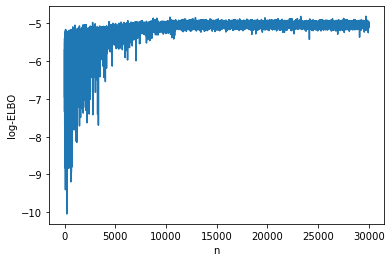

In [1020]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

/Users/eugaddan/Developer/causal_discovery/env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd302448110>,
      dtype=object)

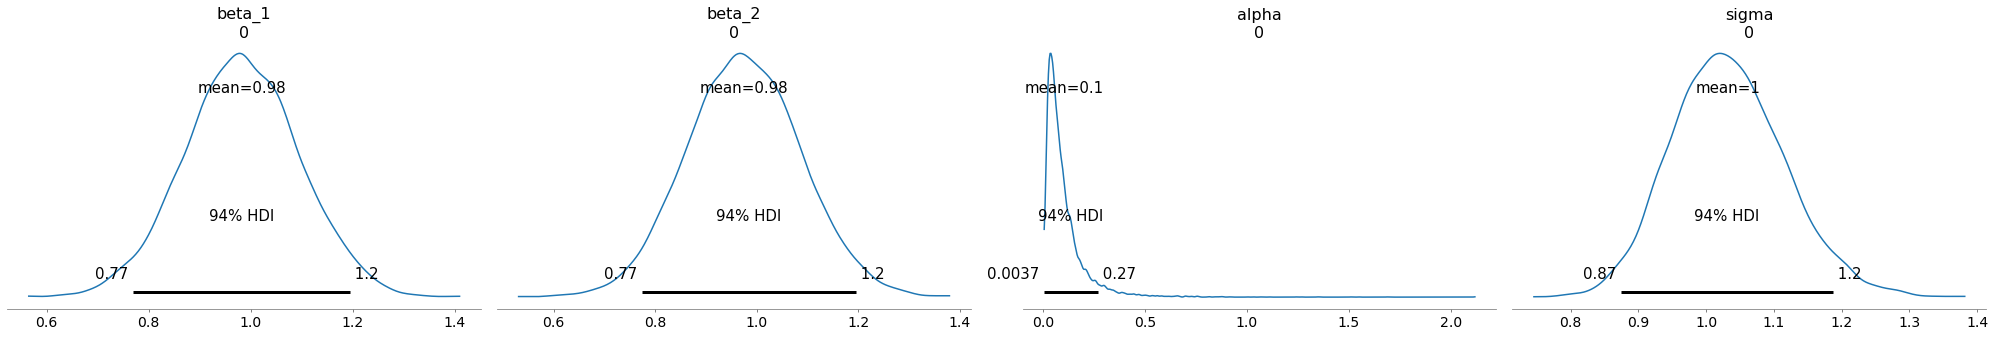

In [1021]:
pm.plot_posterior(advi_fit.sample(10000))

In [966]:
df_5

,x,z,y,R_z
0,-0.296313,-0.382816,-2.037590,False
1,-0.237491,-0.424934,0.692791,False
2,-0.744676,2.153553,2.457501,False
3,1.611437,1.773099,3.253170,False
4,1.138999,-1.323489,0.204069,False
...,...,...,...,...
9995,-2.016625,-0.003577,-0.905110,False
9996,0.502330,0.094214,0.371373,False
9997,1.322663,0.427798,2.502303,False
9998,2.109057,-0.623514,0.547260,False


In [967]:
df_5.at[r_z,'z'] = np.nan

In [968]:
df_5

,x,z,y,R_z
0,-0.296313,-0.382816,-2.037590,False
1,-0.237491,-0.424934,0.692791,False
2,-0.744676,2.153553,2.457501,False
3,1.611437,1.773099,3.253170,False
4,1.138999,-1.323489,0.204069,False
...,...,...,...,...
9995,-2.016625,-0.003577,-0.905110,False
9996,0.502330,0.094214,0.371373,False
9997,1.322663,0.427798,2.502303,False
9998,2.109057,-0.623514,0.547260,False


In [999]:
df_5.isnull().describe()

,x,z,y,R_z
count,10000,10000,10000,10000
unique,1,2,1,1
top,False,False,False,False
freq,10000,9881,10000,10000


In [1122]:
df_5

,x,z,y,R_z
0,0.878379,0.660873,1.207298,False
1,0.662158,0.025570,0.815833,False
2,0.595516,-1.338051,-0.040711,False
3,1.974887,-1.392191,1.472739,False
4,0.261434,-0.124756,-1.585082,False
...,...,...,...,...
995,0.068012,-0.677871,-0.446150,False
996,-0.708455,-0.689112,0.307811,False
997,0.291756,-1.364561,-0.314959,False
998,0.536525,-0.555635,-0.411106,False


In [1126]:
df_5

,x,z,y,R_z
0,0.878379,0.660873,1.207298,False
1,0.662158,0.025570,0.815833,False
2,0.595516,-1.338051,-0.040711,False
3,1.974887,-1.392191,1.472739,False
4,0.261434,-0.124756,-1.585082,False
...,...,...,...,...
995,0.068012,-0.677871,-0.446150,False
996,-0.708455,-0.689112,0.307811,False
997,0.291756,-1.364561,-0.314959,False
998,0.536525,-0.555635,-0.411106,False


In [1158]:
skeleton

['x-y', 'y-z']

In [821]:
df_5['r_z'] * np.nan

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9995   NaN
9996   NaN
9997   NaN
9998   NaN
9999   NaN
Name: r_z, Length: 10000, dtype: float64

In [ ]:
df_randomly_deleted = df_

In [ ]:
SkeletonFinder